# Imports

In [1]:
import tensorflow as tf
import pandas as pd
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys



from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import HeNormal, GlorotNormal

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import f1_score, classification_report, roc_curve, auc, RocCurveDisplay

sys.path.append('./modelos/V1')
from utils import *  # Esto importará todas las funciones y variables definidas en utils.py

# Cargar los datos

In [2]:
# Cargar los CSV
rutaCSV = "../BD/ECGData_ScalogramImgSuavizadas_299_299_csv/"
train_df = pd.read_csv(rutaCSV + "ECGData_ScalogramImgSuavizadas_299_299_Train_stratified.csv")
val_df = pd.read_csv(rutaCSV + "ECGData_ScalogramImgSuavizadas_299_299_Val_stratified.csv")
test_df = pd.read_csv(rutaCSV + "ECGData_ScalogramImgSuavizadas_299_299_Test_stratified.csv")

# Contar instancias en cada conjunto
print(f"Entrenamiento: {len(train_df)} imágenes")
print(f"Validación: {len(val_df)} imágenes")
print(f"Prueba: {len(test_df)} imágenes")

# Separar los canales para cada conjunto
train_canales = separar_por_canales(train_df)
val_canales = separar_por_canales(val_df)
test_canales = separar_por_canales(test_df)

print("\n")

# Mostrar la cantidad de imágenes por canal para cada conjunto
print(f"Entrenamiento: {len(train_canales[CANAL-1])} instacias")
print(f"Validación: {len(val_canales[CANAL-1])} instacias")
print(f"Prueba: {len(test_canales[CANAL-1])} instacias")

Entrenamiento: 81360 imágenes
Validación: 20316 imágenes
Prueba: 25380 imágenes


Entrenamiento: 6780 instacias
Validación: 1693 instacias
Prueba: 2115 instacias


# Estadísticas del conjunto de datos

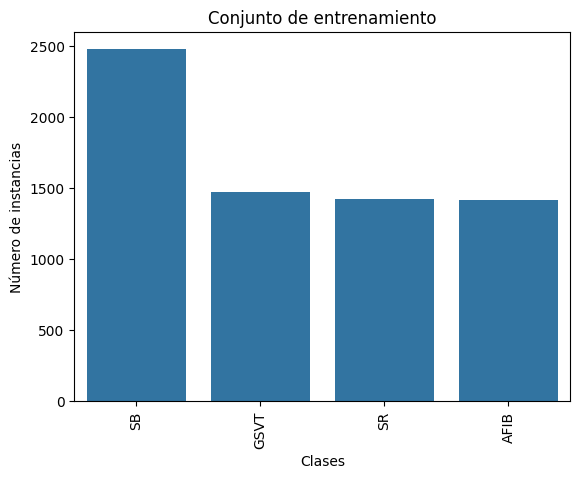

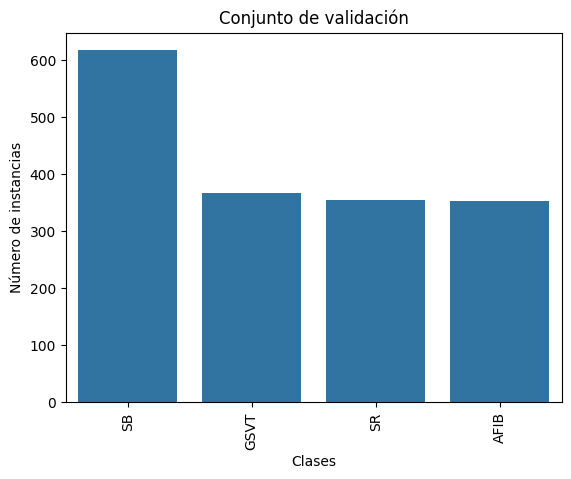

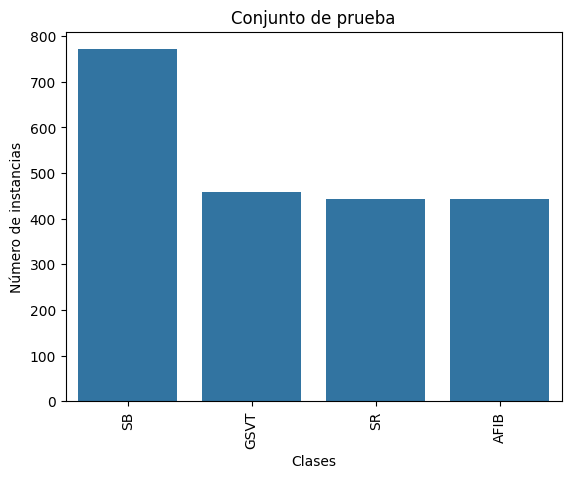

In [3]:
# Graficar la distribución para cada conjunto
plot_class_distribution(train_canales[CANAL-1], 'Conjunto de entrenamiento')
plot_class_distribution(val_canales[CANAL-1], 'Conjunto de validación')
plot_class_distribution(test_canales[CANAL-1], 'Conjunto de prueba')

# Mostrar un ejemplo de cada clase

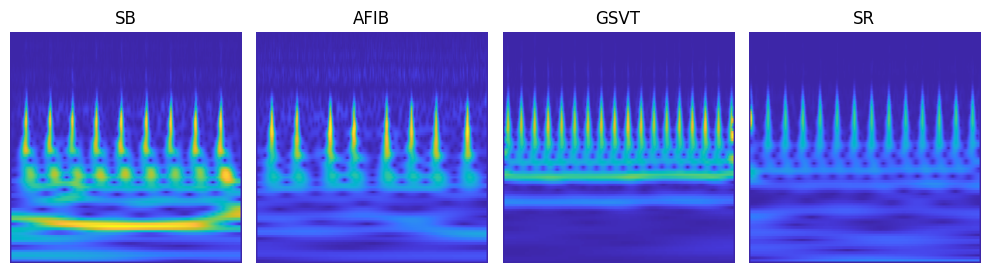

In [3]:
# Obtener las clases únicas
class_labels = train_canales[CANAL-1]['Label'].unique()

# Directorio donde se encuentran las imágenes
directorio = "../BD/"

# Crear una figura para mostrar 4 imágenes
plt.figure(figsize=(10, 5))

for i, label in enumerate(class_labels):
    # Obtener la primera imagen de esta clase
    sample_image_name = train_df[train_df['Label'] == label]['Filepath'].values[0]
    
    # Construir la ruta completa
    image_path = os.path.join(directorio, sample_image_name)
    
    # Leer y mostrar la imagen
    img = cv2.imread(image_path)  # Leer imagen
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB (para mostrar bien los colores)
    
    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

plt.tight_layout()
plt.show()

# Conjunto de datos

## Aumento de datos

In [4]:
# Se aplica aumento de datos en el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Píxeles en el rango [0, 255] -> [0, 1]
    dtype='float32',  # Tipo de dato de las imágenes
    rotation_range=ROTACION_MAX_AD, # Rotación leve
                                    # Si va mal bajarla a 5-8 grados
    width_shift_range=DESPLAZAMIENTO_HORIZONTAL_AD, # Si va mal bajarlo a 5%
    height_shift_range=DESPLAZAMIENTO_VERTICAL_AD, # Si va mal bajarlo a 5%
    brightness_range=BRILLO_AD,  # Pequeñas variaciones de brillo
    # horizontal_flip=True  -> No se aplica porque los ECG son sensibles a la orientación
                            # Cambiaría completamente la señal
    zoom_range=ZOOM_MAX_AD, # zoom pequeño para preservar las características de la imagen (ondas ECG)
    fill_mode='nearest'     # Relleno de píxeles con el valor más cercano
                            # Se pone esta opción para evitar introducir información irrelevante en la
                            # imagen
)

# No se aplica aumento de datos en los conjuntos de validación y prueba (solo se reescalan los píxeles)
test_datagen = ImageDataGenerator(
    rescale=1./255,
    dtype='float32'
)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    dtype='float32'
)

## Crear generadores de datos

In [5]:
# Generar una semilla aleatoria para mezclar los datos de entrenamiento y asegurar la reproducibilidad de
# los resultados
#seed_value = np.random.randint(0, 2**32, dtype='int64')  # Número aleatorio entre 0 y 2^32-1
seed_value = 3185550174  # Semilla fija para reproducibilidad
print(f"Semilla utilizada: {seed_value}")

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_canales[CANAL-1],
    directory=directorio,  
    x_col="Filepath",  # Nombre de la columna con las rutas de imágenes
    y_col="Label",  # Nombre de la columna con las etiquetas
    target_size=IMG_SIZE, # Tamaño al que se redimensionan las imágenes
                            # Inception-v3 requiere imágenes de 299x299
    batch_size=BATCH_SIZE_TRAIN, # mini-lotes de 8
    class_mode='categorical', # one-hot encoding
    shuffle=True,  # Mezclar las imágenes
    seed=seed_value
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_canales[CANAL-1],
    directory=directorio,  
    x_col="Filepath",
    y_col="Label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE_TEST,
    class_mode='categorical',
    shuffle=False  # No mezclar las imágenes para evaluar el modelo
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=val_canales[CANAL-1],
    directory=directorio,
    x_col="Filepath",
    y_col="Label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE_VAL,
    class_mode='categorical'
)

Semilla utilizada: 3185550174
Found 6780 validated image filenames belonging to 4 classes.
Found 2115 validated image filenames belonging to 4 classes.
Found 1693 validated image filenames belonging to 4 classes.


## Mostrar imágenes originales y aumentadas

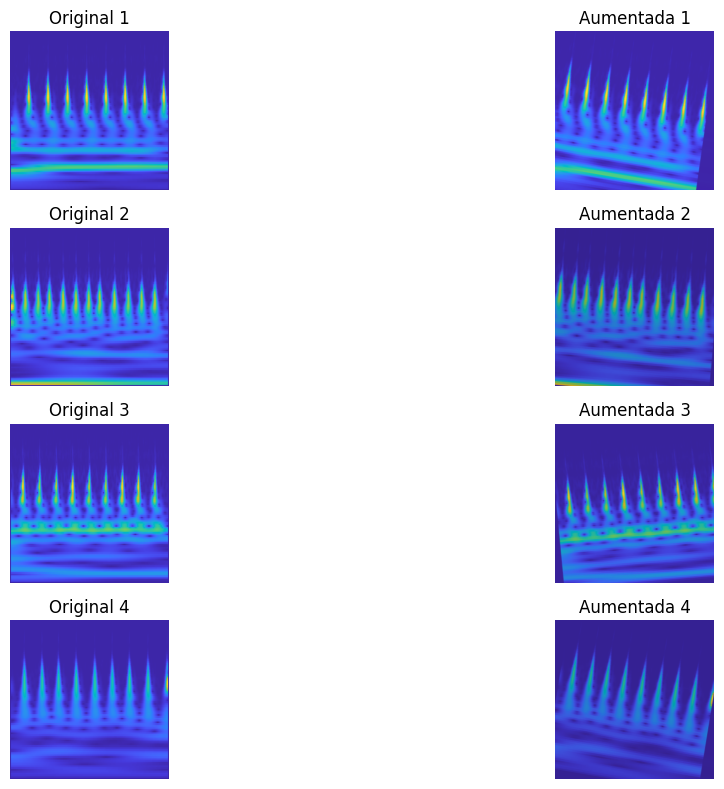

In [7]:
# Como el generador produce imágenes aleatorias (shuffle=True), cada vez que se ejecute la función
# mostrará imágenes diferentes
mostrar_aumento_de_datos(train_generator, num_images=4)

# **Inception-v3**

# Construcción del modelo

### Extracción de características
En Inception-v3, el mapa de características que se extrae del último módulo de inception (Mixed_7c) tiene un tamaño de 8 × 8 × 2048. La aplicación de *average pooling* sobre este mapa de características da como resultado un vector de 1 × 1 × 2048 dimensiones, que se usa como vector de características.

### Clasificación
Consiste en capas completamente conectadas y una función de activación softmax para clasificar los cuatro grupos de registros de ECG.

Se generan valores de predicción en el rango de 0 a 1 para las cuatro etiquetas.

In [6]:
### EXTRACCIÓN DE CARACTERÍSTICAS ###

# Cargar el modelo base preentrenado
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))

# Seleccionar la última capa convolucional "Mixed_7c" como salida del extractor de características:
# Inception-v3 contiene múltiples módulos llamados "Mixed".
# Mixed_7c es la última capa convolucional de Inception-v3, justo antes de la parte de clasificación.
# Genera un mapa de características de tamaño 8x8x2048.
# Esta capa se utiliza para extraer características de las imágenes.
feature_extractor = base_model.get_layer('mixed10').output  # En tensorflow la última capa convolucional
                                                            # es "mixed10". La capa Mixed_7c en la
                                                            # arquitectura original de Inception-v3
                                                            # corresponde a mixed10 en TensorFlow.

# Aplicar Average Pooling para reducir las dimensiones a 1x1x2048
x = GlobalAveragePooling2D()(feature_extractor)



### CLASIFICACIÓN ###

# x = Dropout(0.3)(x)  # Añadir Dropout aquí si hubiera sobreajuste

# Capa completamente conectada (fully connected layer)
# Este tipo de capas es como un "cerebro final" que toma las características extraídas por la red y las
# convierte en predicciones finales con la función de activación ReLU.
x = Dense(NUM_NEURONAS_DENSE1, activation='relu', kernel_initializer=HeNormal())(x)
# Se usa ReLU como función de activación porque ayuda a la red a aprender representaciones no
# lineales
# Se usa HeNormal() como inicializador de pesos porque es adecuado para capas con ReLU.

# Cada vez que agregamos una capa densa grande, las activaciones pueden crecer demasiado o distribuirse de
# manera inestable. BatchNormalization() ayuda a normalizarlas antes de la siguiente transformación no
# lineal (ReLU).
x = BatchNormalization()(x)

# Se desactivan aleatoriamente ciertas neuronas de la capa anterior para evitar que la red dependa
# demasiado de ellas y así prevenir el sobreajuste. En cada etapa del entrenamiento, se apagan diferentes
# neuronas, lo que ayuda a la red a generalizar mejor.
x = Dropout(DROPOUT1)(x) # Ajustar según el rendimiento en el conjunto de validación
                    # Para >= 512 neuronas se recomienda un dropout de 0.5, ya que el riesgo de sobreajuste
                    # es alto

### ¿Por qué BatchNormalization() antes de Dropout()?: ###
# Si ponemos Dropout antes de BatchNormalization, estaríamos normalizando activaciones con valores
# aleatorios eliminados, es decir, con ceros artificiales añadidos por Dropout, no por la capa Dense.

x = Dense(NUM_NEURONAS_DENSE2, activation='relu', kernel_initializer=HeNormal())(x)
x = BatchNormalization()(x)
x = Dropout(DROPOUT2)(x) # Conforme vamos bajando el número de neuronas, podemos reducir el dropout

x = Dense(NUM_NEURONAS_DENSE3, activation='relu', kernel_initializer=HeNormal())(x)
# Aquí no puse BatchNormalization(), porque es una capa más pequeña y ya ha pasado por suficiente
# normalización antes.
x = Dropout(DROPOUT3)(x)

# Capa de salida (función de activación softmax)
output_layer = Dense(NUM_CLASES, activation='softmax', kernel_initializer=GlorotNormal())(x)

# Definir el modelo final
model = Model(inputs=base_model.input, outputs=output_layer)

# Mostrar el resumen del modelo
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

## Entrenamiento

### Métricas

In [9]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'), # sensibilidad
      tf.keras.metrics.AUC(name='auc'),
      #f1_score
]

### Fase 1: Entrenar solo la nueva parte de clasificación

In [10]:
# Freezing Layers: Congelar todas las capas del modelo base
# Se usa un modelo preentrenado (transfer learning)
base_model.trainable = False

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2),
              loss='categorical_crossentropy', # Función de pérdida: cross-entropy
              metrics=METRICS)
# Keras interpreta que es un problema de clasificación multiclase porque la función de pérdida es
# categorical_crossentropy. Con esto, las métricas de precisión, recall y AUC se calculan para cada clase
# y se hace un promedio ponderado (se tiene en cuenta las instancias de cada clase) para obtener un valor
# global.

early_stopping_phase1 = EarlyStopping(monitor='val_loss',
                                      patience=PATIENCE_FASE1,
                                      restore_best_weights=True
                                      )

# Entrenamiento inicial (solo capas de clasificación)
history_phase1 = model.fit(train_generator,
                           validation_data=validation_generator,
                           epochs=EPOCH,
                           callbacks=[early_stopping_phase1]
                           )

# Guardar el modelo incluyendo el valor de seed_value en el nombre del archivo
model.save(f'./modelos/V1/modelo_phase1_{seed_value}.keras')

Epoch 1/500
848/848 [==============================] - 159s 180ms/step - loss: 1.1754 - accuracy: 0.8085 - precision: 0.6310 - recall: 0.5639 - auc: 0.8318 - val_loss: 0.5284 - val_accuracy: 0.9200 - val_precision: 0.8563 - val_recall: 0.8169 - val_auc: 0.9529
Epoch 2/500
848/848 [==============================] - 104s 122ms/step - loss: 0.8899 - accuracy: 0.8571 - precision: 0.7305 - recall: 0.6786 - auc: 0.8959 - val_loss: 0.4434 - val_accuracy: 0.9272 - val_precision: 0.8676 - val_recall: 0.8364 - val_auc: 0.9641
Epoch 3/500
848/848 [==============================] - 105s 123ms/step - loss: 0.7817 - accuracy: 0.8744 - precision: 0.7668 - recall: 0.7152 - auc: 0.9135 - val_loss: 0.3932 - val_accuracy: 0.9338 - val_precision: 0.8821 - val_recall: 0.8488 - val_auc: 0.9703
Epoch 4/500
848/848 [==============================] - 103s 122ms/step - loss: 0.7485 - accuracy: 0.8756 - precision: 0.7685 - recall: 0.7187 - auc: 0.9179 - val_loss: 0.4163 - val_accuracy: 0.9296 - val_precision: 0.

#### Gráfica

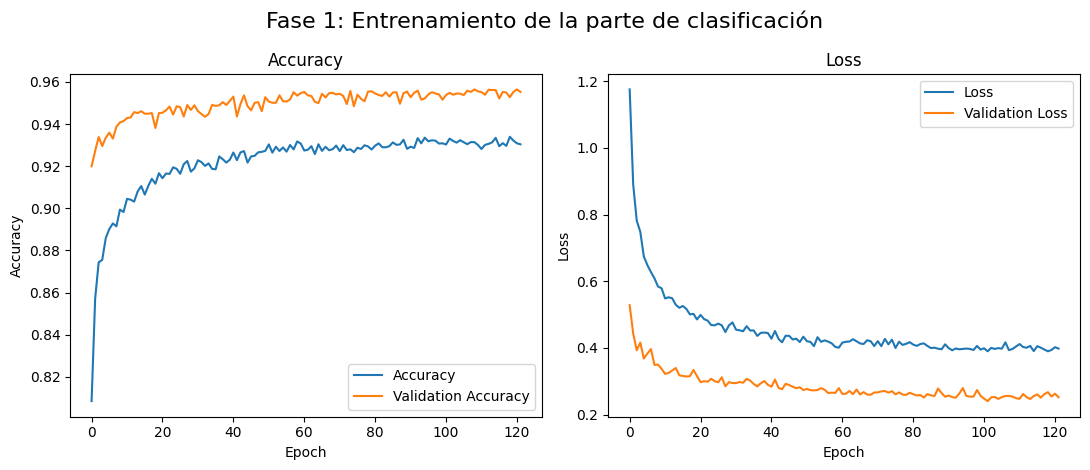

In [11]:
accuracy_phase1 = history_phase1.history['accuracy']
val_accuracy_phase1 = history_phase1.history['val_accuracy']
loss_phase1 = history_phase1.history['loss']
val_loss_phase1 = history_phase1.history['val_loss']

plt.figure(figsize=(11, 5))
plt.suptitle("Fase 1: Entrenamiento de la parte de clasificación", fontsize=16, y=0.93)

plt.subplot(1, 2, 1)
plt.plot(accuracy_phase1, label='Accuracy')
plt.plot(val_accuracy_phase1, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss_phase1, label='Loss')
plt.plot(val_loss_phase1, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar el diseño para que no se superponga con el título
plt.show()

### Fase 2: Fine-Tuning (descongelar algunas capas del backbone)

In [16]:
# Ruta del modelo guardado
model_path = f'./modelos/V1/modelo_phase1_{seed_value}.keras'

# Cargar el modelo
model = load_model_safely(model_path)

Modelo cargado desde ./modelos/V1/modelo_phase1_3185550174.keras


In [12]:
# Descongelar las últimas 30 capas del modelo base (%10 de las capas)
# Se descongelan las últimas capas para que el modelo pueda aprender características específicas de los
# datos de entrenamiento, mientras que las capas anteriores siguen congeladas para mantener las
# características generales aprendidas durante el preentrenamiento.
# Esto es útil para evitar el sobreajuste y mejorar la generalización del modelo.
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2),
              loss='categorical_crossentropy',
              metrics=METRICS)

early_stopping_phase2 = EarlyStopping(monitor='val_loss',
                                      patience=PATIENCE_FASE2,
                                      restore_best_weights=True
                                      )

# Entrenamiento con Fine-Tuning
history_phase2 = model.fit(train_generator,
                           validation_data=validation_generator,
                           epochs=EPOCH,
                           callbacks=[early_stopping_phase2]
                           )

# Guardar el modelo incluyendo el valor de seed_value en el nombre del archivo
model.save(f'./modelos/V1/modelo_phase2_{seed_value}.keras')

Epoch 1/500
848/848 [==============================] - 108s 123ms/step - loss: 0.5134 - accuracy: 0.9200 - precision: 0.8523 - recall: 0.8223 - auc: 0.9614 - val_loss: 0.2739 - val_accuracy: 0.9504 - val_precision: 0.9070 - val_recall: 0.8931 - val_auc: 0.9854
Epoch 2/500
848/848 [==============================] - 103s 122ms/step - loss: 0.4446 - accuracy: 0.9222 - precision: 0.8568 - recall: 0.8268 - auc: 0.9637 - val_loss: 0.2759 - val_accuracy: 0.9510 - val_precision: 0.9072 - val_recall: 0.8955 - val_auc: 0.9850
Epoch 3/500
848/848 [==============================] - 104s 122ms/step - loss: 0.4211 - accuracy: 0.9266 - precision: 0.8642 - recall: 0.8382 - auc: 0.9672 - val_loss: 0.2621 - val_accuracy: 0.9563 - val_precision: 0.9190 - val_recall: 0.9049 - val_auc: 0.9866
Epoch 4/500
848/848 [==============================] - 103s 122ms/step - loss: 0.4193 - accuracy: 0.9301 - precision: 0.8723 - recall: 0.8440 - auc: 0.9669 - val_loss: 0.2424 - val_accuracy: 0.9584 - val_precision: 0.

#### Gráfica

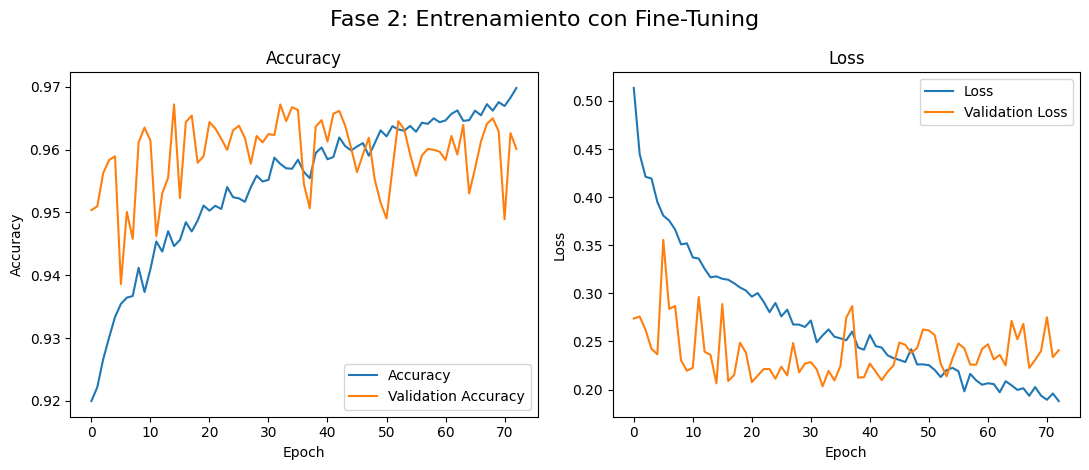

In [13]:
accuracy_phase2 = history_phase2.history['accuracy']
val_accuracy_phase2 = history_phase2.history['val_accuracy']
loss_phase2 = history_phase2.history['loss']
val_loss_phase2 = history_phase2.history['val_loss']

plt.figure(figsize=(11, 5))
plt.suptitle("Fase 2: Entrenamiento con Fine-Tuning", fontsize=16, y=0.93)

plt.subplot(1, 2, 1)
plt.plot(accuracy_phase2, label='Accuracy')
plt.plot(val_accuracy_phase2, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss_phase2, label='Loss')
plt.plot(val_loss_phase2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar el diseño para que no se superponga con el título
plt.show()

In [7]:
# Ruta del modelo guardado
model_path = f'./modelos/V1/modelo_phase2_{seed_value}.keras'

# Cargar el modelo
model = load_model_safely(model_path)

Modelo cargado desde ./modelos/V1/modelo_phase2_3185550174.keras


### Mostrar resultados finales de entrenamiento-validación

#### Primer modelo

In [17]:
# Evaluar sobre entrenamiento
train_loss, train_accuracy, train_precision, train_recall, train_auc = model.evaluate(train_generator)
print("\n📊 Resultados en el conjunto de ENTRENAMIENTO:")
print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Train Recall: {train_recall:.4f}")
print(f"Train AUC: {train_auc:.4f}")
print(f"Train F1-Score: {f1_score(train_recall, train_precision):.4f}\n")

# Evaluar sobre validación
val_loss, val_accuracy, val_precision, val_recall, val_auc = model.evaluate(validation_generator)
print("\n📊 Resultados en el conjunto de VALIDACIÓN:")
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")
print(f"Val AUC: {val_auc:.4f}")
print(f"Val F1-Score: {f1_score(val_recall, val_precision):.4f}")

# Crear un DataFrame con los resultados
resultados = pd.DataFrame({
    '': ['Entrenamiento', 'Validación'],
    'Loss': [train_loss, val_loss],
    'Accuracy': [train_accuracy, val_accuracy],
    'Precisión': [train_precision, val_precision],
    'Sensibilidad': [train_recall, val_recall],
    'AUC': [train_auc, val_auc],
    'F1-Score': [f1_score(train_recall, train_precision), f1_score(val_recall, val_precision)]
})

# Guardar el DataFrame en un archivo Excel
ruta_excel = './modelos/V1/resultados_entrenamiento_validacion_fase1.xlsx'
resultados.to_excel(ruta_excel, index=False)

print(f"📁 Resultados guardados en: {ruta_excel}")

848/848 [==============================] - 100s 117ms/step - loss: 0.2751 - accuracy: 0.9537 - precision: 0.9111 - recall: 0.9027 - auc: 0.9847

📊 Resultados en el conjunto de ENTRENAMIENTO:
Train Loss: 0.2751
Train Accuracy: 0.9537
Train Precision: 0.9111
Train Recall: 0.9027
Train AUC: 0.9847
Train F1-Score: 0.9069

14/14 [==============================] - 4s 254ms/step - loss: 0.2406 - accuracy: 0.9548 - precision: 0.9150 - recall: 0.9031 - auc: 0.9887

📊 Resultados en el conjunto de VALIDACIÓN:
Val Loss: 0.2406
Val Accuracy: 0.9548
Val Precision: 0.9150
Val Recall: 0.9031
Val AUC: 0.9887
Val F1-Score: 0.9090
📁 Resultados guardados en: ./modelos/V1/resultados_entrenamiento_validacion_fase1.xlsx


#### Segundo modelo

In [14]:
# Evaluar sobre entrenamiento
train_loss, train_accuracy, train_precision, train_recall, train_auc = model.evaluate(train_generator)
print("\n📊 Resultados en el conjunto de ENTRENAMIENTO:")
print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Train Recall: {train_recall:.4f}")
print(f"Train AUC: {train_auc:.4f}")
print(f"Train F1-Score: {f1_score(train_recall, train_precision):.4f}\n")

# Evaluar sobre validación
val_loss, val_accuracy, val_precision, val_recall, val_auc = model.evaluate(validation_generator)
print("\n📊 Resultados en el conjunto de VALIDACIÓN:")
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")
print(f"Val AUC: {val_auc:.4f}")
print(f"Val F1-Score: {f1_score(val_recall, val_precision):.4f}")

# Crear un DataFrame con los resultados
resultados = pd.DataFrame({
    '': ['Entrenamiento', 'Validación'],
    'Loss': [train_loss, val_loss],
    'Accuracy': [train_accuracy, val_accuracy],
    'Precisión': [train_precision, val_precision],
    'Sensibilidad': [train_recall, val_recall],
    'AUC': [train_auc, val_auc],
    'F1-Score': [f1_score(train_recall, train_precision), f1_score(val_recall, val_precision)]
})

# Guardar el DataFrame en un archivo Excel
ruta_excel = './modelos/V1/resultados_entrenamiento_validacion_fase2.xlsx'
resultados.to_excel(ruta_excel, index=False)

print(f"📁 Resultados guardados en: {ruta_excel}")

848/848 [==============================] - 99s 116ms/step - loss: 0.1771 - accuracy: 0.9693 - precision: 0.9407 - recall: 0.9361 - auc: 0.9939

📊 Resultados en el conjunto de ENTRENAMIENTO:
Train Loss: 0.1771
Train Accuracy: 0.9693
Train Precision: 0.9407
Train Recall: 0.9361
Train AUC: 0.9939
Train F1-Score: 0.9384

14/14 [==============================] - 4s 258ms/step - loss: 0.2035 - accuracy: 0.9672 - precision: 0.9375 - recall: 0.9309 - auc: 0.9911

📊 Resultados en el conjunto de VALIDACIÓN:
Val Loss: 0.2035
Val Accuracy: 0.9672
Val Precision: 0.9375
Val Recall: 0.9309
Val AUC: 0.9911
Val F1-Score: 0.9342
📁 Resultados guardados en: ./modelos/V1/resultados_entrenamiento_validacion_fase2.xlsx


# Predicción

## Evaluar el modelo en el conjunto de prueba

### Primer modelo

In [18]:
if model is not None:
    test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Test Precision: {test_precision}")
    print(f"Test Recall: {test_recall}")
    print(f"Test AUC: {test_auc}")
    print(f"Test F1-Score: {f1_score(test_recall, test_precision)}")
else:
    print("No se pudo cargar el modelo para la evaluación.")

17/17 [==============================] - 5s 270ms/step - loss: 0.2943 - accuracy: 0.9505 - precision: 0.9050 - recall: 0.8960 - auc: 0.9827
Test Loss: 0.2943050265312195
Test Accuracy: 0.9504728317260742
Test Precision: 0.9049665927886963
Test Recall: 0.8959810733795166
Test AUC: 0.9827062487602234
Test F1-Score: 0.9004513672315871


### Segundo modelo

In [15]:
if model is not None:
    test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Test Precision: {test_precision}")
    print(f"Test Recall: {test_recall}")
    print(f"Test AUC: {test_auc}")
    print(f"Test F1-Score: {f1_score(test_recall, test_precision)}")
else:
    print("No se pudo cargar el modelo para la evaluación.")

17/17 [==============================] - 15s 922ms/step - loss: 0.2565 - accuracy: 0.9583 - precision: 0.9187 - recall: 0.9139 - auc: 0.9862
Test Loss: 0.25648194551467896
Test Accuracy: 0.958274245262146
Test Precision: 0.9187262654304504
Test Recall: 0.9139479994773865
Test AUC: 0.9862027168273926
Test F1-Score: 0.916330853353445


## Curva ROC

17/17 [==============================] - 19s 872ms/step


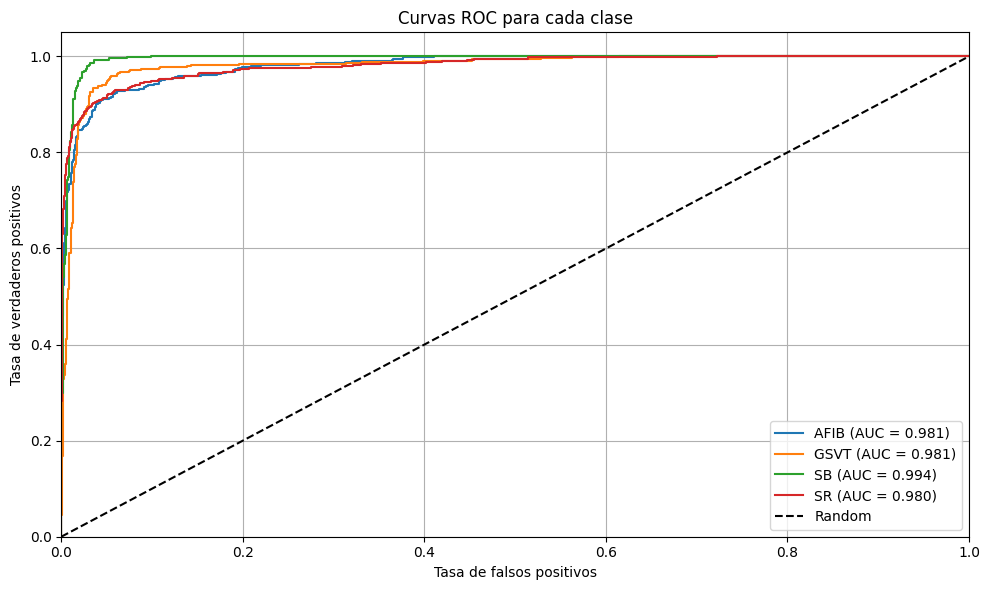

In [8]:
# Predicciones en el conjunto de prueba
predictions = model.predict(test_generator)
#predicted_classes = np.argmax(predictions, axis=1)  # Obtener las clases predichas
true_classes = test_generator.classes  # Obtener las clases verdaderas
true_classes_one_hot = to_categorical(true_classes, num_classes=NUM_CLASES)    # Convertir true_classes
                                                                                # a One-Hot Encoding
class_labels = list(test_generator.class_indices.keys())  # Obtener las etiquetas de clase

# Graficar la curva ROC para cada clase (problema multiclase)
# Enfoque One-vs-Rest: calcular la curva ROC para cada clase contra el resto
# Para cada clase, se considera esa clase como positiva y todas las demás como negativas.
# Esto permite evaluar el rendimiento del modelo en cada clase individualmente.
# Cada curva ROC muestra cómo de bien el modelo distingue esa clase concreta del resto.
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASES):
    fpr[i], tpr[i], _ = roc_curve(true_classes_one_hot[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Dibujar todas las curvas ROC en una sola figura
plt.figure(figsize=(10, 6))
for i in range(NUM_CLASES):
    plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curvas ROC para cada clase')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## Matriz de confusión

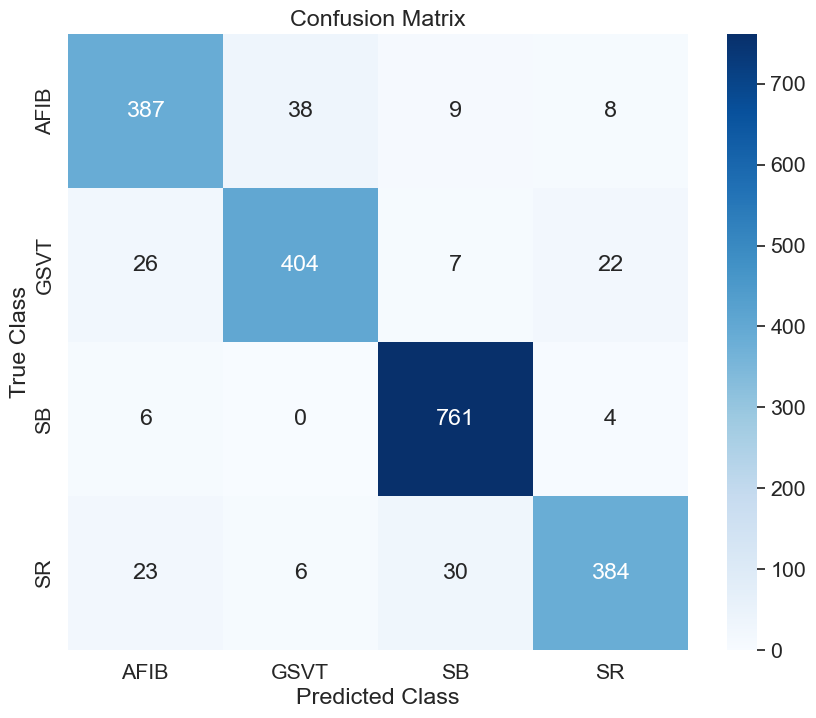

In [21]:
predicted_classes = np.argmax(predictions, axis=1)  # Obtener las clases predichas

# Graficar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.4)  # Aumentar el tamaño de la fuente para la matriz de confusión
sns.heatmap(confusion_matrix(true_classes, predicted_classes), annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

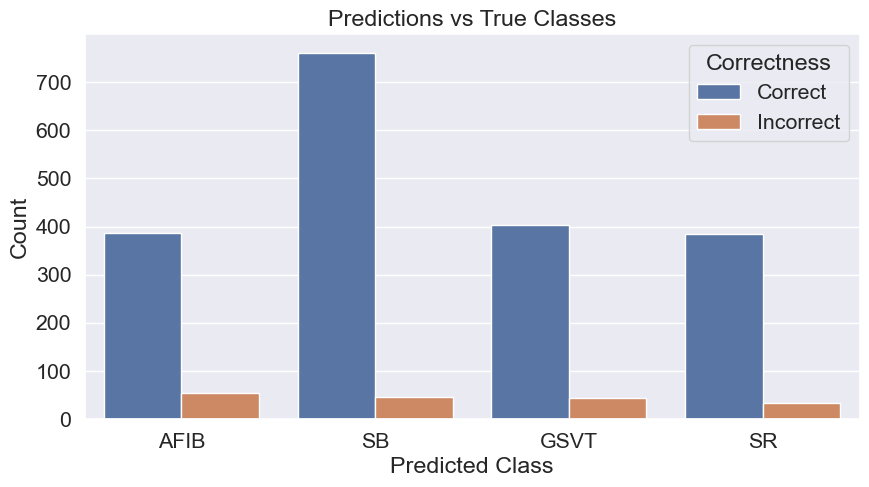

              precision    recall  f1-score   support

        AFIB       0.88      0.88      0.88       442
        GSVT       0.90      0.88      0.89       459
          SB       0.94      0.99      0.96       771
          SR       0.92      0.87      0.89       443

    accuracy                           0.92      2115
   macro avg       0.91      0.90      0.91      2115
weighted avg       0.91      0.92      0.91      2115



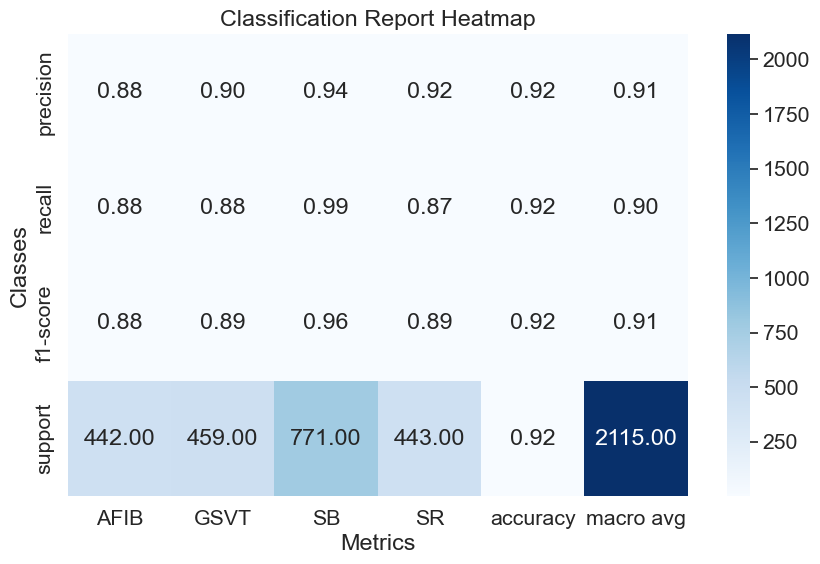

In [22]:
# Crear un DataFrame para las predicciones y las clases verdaderas
pred_df = pd.DataFrame({
    'True Class': [class_labels[i] for i in true_classes],
    'Predicted Class': [class_labels[i] for i in predicted_classes]
})
pred_df['Correct'] = pred_df['True Class'] == pred_df['Predicted Class']
pred_df['Correct'] = pred_df['Correct'].map({True: 'Correct', False: 'Incorrect'})

# Graficar las predicciones
plt.figure(figsize=(10, 5))
sns.countplot(data=pred_df, x='Predicted Class', hue='Correct')
plt.title('Predictions vs True Classes')
plt.xlabel('Predicted Class')
plt.ylabel('Count')
plt.legend(title='Correctness')
plt.show()

# Graficar el reporte de clasificación
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Graficar el reporte de clasificación como un heatmap
report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f')
plt.title('Classification Report Heatmap')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.show()

# macro avg y weighted avg son promedios de las métricas para todas las clases
# macro avg: Promedio simple de las métricas para todas las clases (sin ponderar por el número de
# instancias)
# weighted avg: Promedio ponderado por el número de instancias en cada clase (más representativo si hay
# clases desbalanceadas)